# Do spikes in fics published correspond w something?

## Set up

In [53]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import scipy
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, from_networkx, output_file, save
from bokeh.models import HoverTool, ColorBar, LinearColorMapper
from bokeh.transform import linear_cmap
from bokeh.layouts import column
import matplotlib.colors as mcolors
from bokeh.embed import file_html
from bokeh.resources import CDN

np.random.seed(seed=42)
sns.set_context("paper")
plt.rcParams['font.family'] = 'sans-serif'
sns.set_palette("deep")
sns.set_style("white")


In [54]:
tags = pd.read_csv("tags-20210226.csv")
works = pd.read_csv("works-20210226.csv")

In [55]:
# process tags
works['tags'] = works['tags'].astype(str).apply(lambda tags: tags.split('+'))
fandoms = tags[tags['type'] == "Fandom"]

## Main Prompt

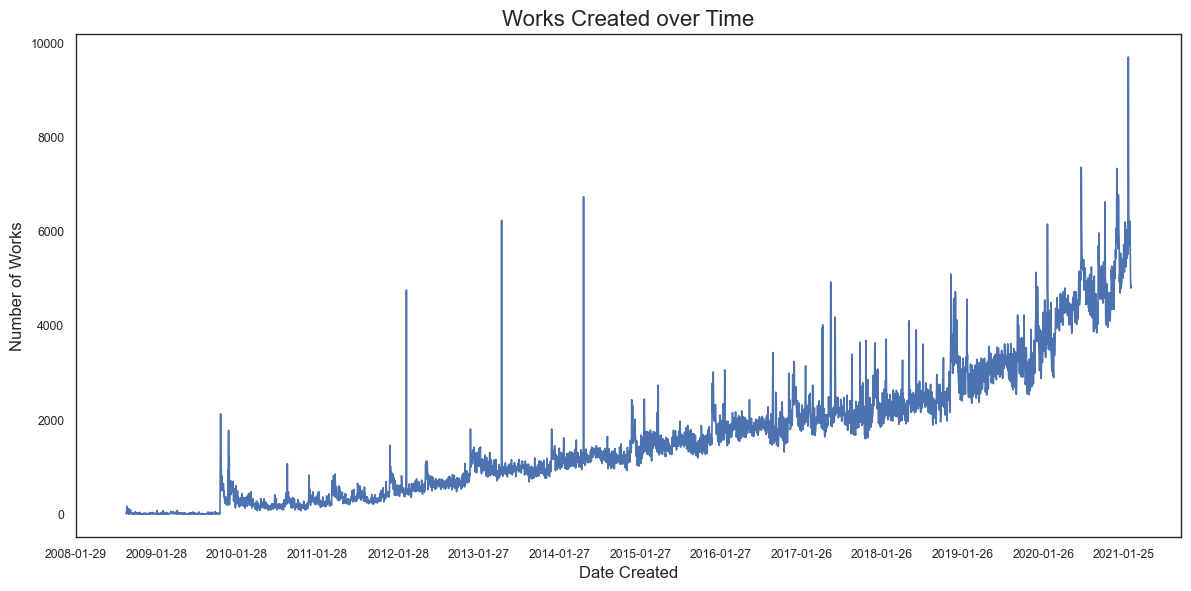

In [56]:
works["creation date"] = pd.to_datetime(works["creation date"])

works_dates = works['creation date'].value_counts().sort_index().reset_index()
works_dates.columns = ['date', 'works']

plt.figure(figsize=(12,6))
ax = sns.lineplot(x="date", y="works", data=works_dates)

# Customize the plot
plt.title('Works Created over Time', fontsize=16)
plt.xlabel('Date Created', fontsize=12)
plt.ylabel('Number of Works', fontsize=12)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 365))

# Show the plot
plt.tight_layout()
plt.show()


In [32]:
# check
len(np.unique(works['creation date'])) == len(works_dates)

True

## Investigation

### Spikes
Focus on 3 biggest spikes? early 2012, mid 2013, mid 2014

In [33]:
# early 2012
early_2012 = works_dates.loc[(works_dates['date'] > '2012-01-28') & (works_dates['date'] < '2012-05-01')]
spike_2012 = early_2012[early_2012['works'] == max(early_2012['works'])]
print("Spike day in 2012: ", spike_2012['date'])

Spike day in 2012:  1248   2012-03-05
Name: date, dtype: datetime64[ns]


In [34]:
# mid 2013
mid_2013 = works_dates.loc[(works_dates['date'] > '2013-01-27') & (works_dates['date'] < '2014-01-01')]
spike_2013 = mid_2013[mid_2013['works'] == max(mid_2013['works'])]
print("Spike day in 2013: ", spike_2013['date'])

Spike day in 2013:  1679   2013-05-10
Name: date, dtype: datetime64[ns]


In [35]:
# mid 2014
mid_2014 = works_dates.loc[(works_dates['date'] > '2014-01-27') & (works_dates['date'] < '2015-01-01')]
spike_2014 = mid_2014[mid_2014['works'] == max(mid_2014['works'])]
print("Spike day in 2014: ", spike_2014['date'])

Spike day in 2014:  2050   2014-05-16
Name: date, dtype: datetime64[ns]


In [36]:
works['creation date'] = works['creation date'].apply(lambda x: x.date())


### Major fandoms during spikes

#### 2012-03-05

In [37]:
# Ensure the date columns are of datetime.date type
works['creation date'] = pd.to_datetime(works['creation date']).dt.date
spike_2012['date'] = pd.to_datetime(spike_2012['date']).dt.date

spike_2012_works = works[works['creation date'] == spike_2012['date'].iloc[0]]

# check
if len(spike_2012_works) == spike_2012['works'].iloc[0]:
    print("Yay! The number of works at the spike is", len(spike_2012_works))
else: 
    print("ugh")

Yay! The number of works at the spike is 4752


/var/folders/lk/jwtj64_565zdwjrcvb73p4dc0000gn/T/ipykernel_75855/513719139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_2012['date'] = pd.to_datetime(spike_2012['date']).dt.date


In [38]:
# Explode the lists in the "tags" column into individual rows
exploded_spike_2012_works = spike_2012_works.explode('tags')

# Count the occurrences of each unique integer
tag_counts_spike_2012_works = exploded_spike_2012_works['tags'].value_counts().reset_index()

# Rename the columns to "id" and "count"
tag_counts_spike_2012_works.columns = ['id', 'count']

tag_counts_spike_2012_works

,id,count
0,23,4251
1,187,4185
2,14,4080
3,188,3534
4,13,1633
...,...,...
2686,30842036,1
2687,88868,1
2688,84399,1
2689,2162,1


In [39]:
# Ensure the "id" columns in both DataFrames are of the same type (int64)
tag_counts_spike_2012_works.loc[:, 'id'] = tag_counts_spike_2012_works['id'].astype(int)
fandoms.loc[:, 'id'] = fandoms['id'].astype(int)

# Merge the DataFrames on the "id" column
fandom_counts_spike_2012_works = pd.merge(fandoms, tag_counts_spike_2012_works, on='id', how='left')

# Replace NaN values in the "count" column with 0
# fandom_counts_spike_2012_works['count'] = fandom_counts_spike_2012_works['count'].fillna(0).as,type(int)

fandom_counts_spike_2012_works.head()

,id,type,name,canonical,cached_count,merger_id,count
0,27,Fandom,Supernatural,True,310300,NaN,31.0
1,31,Fandom,Redacted,False,5,25968.0,NaN
2,37,Fandom,Boondock Saints (1999),False,47,223663.0,NaN
3,46,Fandom,Lord of the Rings RPF,False,3538,71193.0,NaN
4,56,Fandom,Gravitation (Anime),False,6,2769.0,NaN


In [40]:
# SORT YAY

fandom_counts_spike_2012_works = fandom_counts_spike_2012_works.sort_values(by='count', ascending=False)
fandom_counts_spike_2012_works.head()

,id,type,name,canonical,cached_count,merger_id,count
18,187,Fandom,Smallville,True,14993,NaN,4185.0
285,3549,Fandom,Hikaru no Go,False,2627,49686766.0,42.0
7356,117807,Fandom,Homestuck,True,67200,NaN,41.0
8312,133185,Fandom,Sherlock (TV),True,151925,NaN,35.0
0,27,Fandom,Supernatural,True,310300,NaN,31.0


In [41]:
tags[tags['id'] == 188]

,id,type,name,canonical,cached_count,merger_id
169,188,Relationship,Clark/Lex,False,3853,5275.0


Okay, so the majority of the fics put out on this day were from Smallville! And 3853 out of the 4185 fics were tagged Clark/Lex. The date was 2012-03-05. What happened then?

Can't really tell, but it's weird because the Smallville TV series ended with Season 10 on May 13, 2011, long before 2012. Keep in mind that these fics were *posted* on 2012-03-5. 

After looking around online, it seems that the only thing of note I could find in the news about Smallville between Feb 1, 2012, to March 5, 2012, was that Seaon 11 of the series would continue in a digital comic, picking up 6 months after the events of Season 10: https://m.imdb.com/news/ni22484166/

Maybe the news of a beloved TV series being back gave a bunch of fic authors the inspiration to start again?


ACTUALLY NAH. it was because a the Smallville Slash Archive was ported over to AO3: https://fanlore.org/wiki/Smallville_Slash_Archive

#### 2013-05-10

In [42]:
# Ensure the date columns are of datetime.date type
spike_2013['date'] = pd.to_datetime(spike_2013['date']).dt.date

spike_2013_works = works[works['creation date'] == spike_2013['date'].iloc[0]]

# check
if len(spike_2013_works) == spike_2013['works'].iloc[0]:
    print("Yay! The number of works at the spike is", len(spike_2013_works))
else: 
    print("ugh")

Yay! The number of works at the spike is 6233


/var/folders/lk/jwtj64_565zdwjrcvb73p4dc0000gn/T/ipykernel_75855/71429614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_2013['date'] = pd.to_datetime(spike_2013['date']).dt.date


In [43]:
# Explode the lists in the "tags" column into individual rows
exploded_spike_2013_works = spike_2013_works.explode('tags')

# Count the occurrences of each unique integer
tag_counts_spike_2013_works = exploded_spike_2013_works['tags'].value_counts().reset_index()

# Rename the columns to "id" and "count"
tag_counts_spike_2013_works.columns = ['id', 'count']

tag_counts_spike_2013_works

,id,count
0,23,5616
1,273,5431
2,14,4820
3,485,4484
4,13,2680
...,...,...
4742,877505,1
4743,374174,1
4744,877506,1
4745,33074,1


In [44]:
# Ensure the "id" columns in both DataFrames are of the same type (int64)
tag_counts_spike_2013_works.loc[:, 'id'] = tag_counts_spike_2013_works['id'].astype(int)

# Merge the DataFrames on the "id" column
fandom_counts_spike_2013_works = pd.merge(fandoms, tag_counts_spike_2013_works, on='id', how='left')

# Replace NaN values in the "count" column with 0
# fandom_counts_spike_2012_works['count'] = fandom_counts_spike_2012_works['count'].fillna(0).as,type(int)

fandom_counts_spike_2013_works.head()

,id,type,name,canonical,cached_count,merger_id,count
0,27,Fandom,Supernatural,True,310300,NaN,56.0
1,31,Fandom,Redacted,False,5,25968.0,NaN
2,37,Fandom,Boondock Saints (1999),False,47,223663.0,NaN
3,46,Fandom,Lord of the Rings RPF,False,3538,71193.0,NaN
4,56,Fandom,Gravitation (Anime),False,6,2769.0,NaN


In [45]:
# SORT YAY

fandom_counts_spike_2013_works = fandom_counts_spike_2013_works.sort_values(by='count', ascending=False)
fandom_counts_spike_2013_works.head()

,id,type,name,canonical,cached_count,merger_id,count
26,273,Fandom,The Sentinel,False,13227,41796.0,5431.0
0,27,Fandom,Supernatural,True,310300,NaN,56.0
13287,266936,Fandom,The Avengers (2012),False,30056,1001939.0,42.0
12930,258526,Fandom,Teen Wolf (TV),True,172802,NaN,38.0
18038,449545,Fandom,One Direction (Band),True,68098,NaN,35.0


In [46]:
tags[tags['id'] == 485]

,id,type,name,canonical,cached_count,merger_id
395,485,Relationship,Jim Ellison/Blair Sandburg,True,9006,NaN


Same as above: 852 Prospect, an archive for adult fanfiction based on the TV show The Sentinel

also the source of the sentinal/guide AU! https://fanlore.org/wiki/Sentinel_AU

#### 2014-05-16

In [47]:
# Ensure the date columns are of datetime.date type
spike_2014['date'] = pd.to_datetime(spike_2014['date']).dt.date

spike_2014_works = works[works['creation date'] == spike_2014['date'].iloc[0]]

# check
if len(spike_2014_works) == spike_2014['works'].iloc[0]:
    print("Yay! The number of works at the spike is", len(spike_2014_works))
else: 
    print("ugh")

/var/folders/lk/jwtj64_565zdwjrcvb73p4dc0000gn/T/ipykernel_75855/1797549676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_2014['date'] = pd.to_datetime(spike_2014['date']).dt.date


Yay! The number of works at the spike is 6732


In [48]:
# Explode the lists in the "tags" column into individual rows
exploded_spike_2014_works = spike_2014_works.explode('tags')

# Count the occurrences of each unique integer
tag_counts_spike_2014_works = exploded_spike_2014_works['tags'].value_counts().reset_index()

# Rename the columns to "id" and "count"
tag_counts_spike_2014_works.columns = ['id', 'count']

tag_counts_spike_2014_works.head(10)

,id,count
0,14,5422
1,10,3261
2,11,1850
3,16,1230
4,12,899
5,23,892
6,13,611
7,21,566
8,22,536
9,116,139


In [49]:
# Ensure the "id" columns in both DataFrames are of the same type (int64)
tag_counts_spike_2014_works.loc[:, 'id'] = tag_counts_spike_2014_works['id'].astype(int)

# Merge the DataFrames on the "id" column
fandom_counts_spike_2014_works = pd.merge(fandoms, tag_counts_spike_2014_works, on='id', how='left')

# Replace NaN values in the "count" column with 0
# fandom_counts_spike_2012_works['count'] = fandom_counts_spike_2012_works['count'].fillna(0).as,type(int)

fandom_counts_spike_2014_works.head()

,id,type,name,canonical,cached_count,merger_id,count
0,27,Fandom,Supernatural,True,310300,NaN,83.0
1,31,Fandom,Redacted,False,5,25968.0,NaN
2,37,Fandom,Boondock Saints (1999),False,47,223663.0,NaN
3,46,Fandom,Lord of the Rings RPF,False,3538,71193.0,NaN
4,56,Fandom,Gravitation (Anime),False,6,2769.0,NaN


In [50]:
# SORT YAY

fandom_counts_spike_2014_works = fandom_counts_spike_2014_works.sort_values(by='count', ascending=False)
fandom_counts_spike_2014_works.head(10)

,id,type,name,canonical,cached_count,merger_id,count
0,27,Fandom,Supernatural,True,310300,NaN,83.0
22481,586439,Fandom,Captain America (Movies),True,95654,NaN,54.0
29600,930966,Fandom,Fairy Tales & Related Fandoms,True,1286,NaN,54.0
8312,133185,Fandom,Sherlock (TV),True,151925,NaN,48.0
17031,414093,Fandom,Marvel Cinematic Universe,True,240536,NaN,48.0
8582,136512,Fandom,Harry Potter - J. K. Rowling,True,361919,NaN,45.0
8197,131997,Fandom,Discworld - Terry Pratchett,True,3072,NaN,43.0
920,13155,Fandom,Greek and Roman Mythology,False,3216,31695445.0,40.0
30877,1001939,Fandom,The Avengers (Marvel Movies),True,157813,NaN,38.0
12930,258526,Fandom,Teen Wolf (TV),True,172802,NaN,37.0


In [51]:
# a bit strange but still a spike?
mid_2014.sort_values(by='works', ascending=False).head()

# lowkey can tell people write around christmas time LOL

,date,works
2050,2014-05-16,6732
2268,2014-12-20,2425
2272,2014-12-24,2305
2273,2014-12-25,1921
2271,2014-12-23,1838


<Axes: xlabel='count', ylabel='name'>

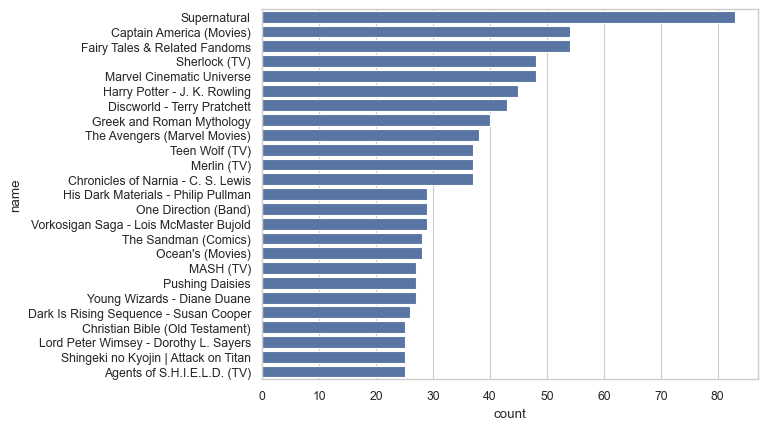

In [52]:
sns.barplot(fandom_counts_spike_2014_works.head(25), x="count", y="name", orient='y')


maybe it's like livejournal? or ff.net?

but can't find any imports in the news...

OH I GOT IT! Yuletide! https://www.transformativeworks.org/yuletide-archive-move-complete/ 
https://fanlore.org/wiki/Yuletide